In [1]:
import torch
import torch.nn as nn
import random
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from tqdm import tqdm
import pickle 
from gym_super_mario_bros.actions import RIGHT_ONLY, SIMPLE_MOVEMENT, COMPLEX_MOVEMENT
import gym
import numpy as np
import collections 
import cv2
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
import time
import pylab as pl
from IPython import display

In [2]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs

class MarioRescale84x84(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(MarioRescale84x84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return MarioRescale84x84.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 240 * 256 * 3:
            img = np.reshape(frame, [240, 256, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution." 
        # image normalization on RBG
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)

class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)

class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer

class PixelNormalization(gym.ObservationWrapper):
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0

In [3]:
def create_mario_env(env):
    env = MaxAndSkipEnv(env)
    env = MarioRescale84x84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    env = PixelNormalization(env)
    return JoypadSpace(env, [['right'], ['right', 'A']])

In [4]:
class DQNSolver(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQNSolver, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

class DQNAgent:
    def __init__(self, state_space, action_space, max_memory_size, batch_size, gamma, lr,
                 dropout, exploration_max, exploration_min, exploration_decay, double_dqn, pretrained):

        # Define DQN Layers
        self.state_space = state_space
        self.action_space = action_space
        self.double_dqn = double_dqn
        self.pretrained = pretrained
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        # Double DQN network
        if self.double_dqn:  
            self.local_net = DQNSolver(state_space, action_space).to(self.device)
            self.target_net = DQNSolver(state_space, action_space).to(self.device)
            
            if self.pretrained:
                self.local_net.load_state_dict(torch.load("../checkpoints/DQN/DQN1.pt", map_location=torch.device(self.device)))
                self.target_net.load_state_dict(torch.load("../checkpoints/DQN/DQN2.pt", map_location=torch.device(self.device)))
                    
            self.optimizer = torch.optim.Adam(self.local_net.parameters(), lr=lr)
            self.copy = 5000  # Copy the local model weights into the target network every 5000 steps
            self.step = 0
        # DQN network
        else:  
            self.dqn = DQNSolver(state_space, action_space).to(self.device)
            
            if self.pretrained:
                self.dqn.load_state_dict(torch.load("../checkpoints/DQN/DQN.pt", map_location=torch.device(self.device)))
            self.optimizer = torch.optim.Adam(self.dqn.parameters(), lr=lr)

        # Create memory
        self.max_memory_size = max_memory_size
        if self.pretrained:
            self.STATE_MEM = torch.load("../checkpoints/DQN/STATE_MEM.pt")
            self.ACTION_MEM = torch.load("../checkpoints/DQN/ACTION_MEM.pt")
            self.REWARD_MEM = torch.load("../checkpoints/DQN/REWARD_MEM.pt")
            self.STATE2_MEM = torch.load("../checkpoints/DQN/STATE2_MEM.pt")
            self.DONE_MEM = torch.load("../checkpoints/DQN/DONE_MEM.pt")
            with open("../checkpoints/DQN/ending_position.pkl", 'rb') as f:
                self.ending_position = pickle.load(f)
            with open("../checkpoints/DQN/num_in_queue.pkl", 'rb') as f:
                self.num_in_queue = pickle.load(f)
        else:
            self.STATE_MEM = torch.zeros(max_memory_size, *self.state_space)
            self.ACTION_MEM = torch.zeros(max_memory_size, 1)
            self.REWARD_MEM = torch.zeros(max_memory_size, 1)
            self.STATE2_MEM = torch.zeros(max_memory_size, *self.state_space)
            self.DONE_MEM = torch.zeros(max_memory_size, 1)
            self.ending_position = 0
            self.num_in_queue = 0
        
        self.memory_sample_size = batch_size
        
        # Learning parameters
        self.gamma = gamma
        self.l1 = nn.SmoothL1Loss().to(self.device) # Also known as Huber loss
        self.exploration_max = exploration_max
        self.exploration_rate = exploration_max
        self.exploration_min = exploration_min
        self.exploration_decay = exploration_decay

    def remember(self, state, action, reward, state2, done):
        self.STATE_MEM[self.ending_position] = state.float()
        self.ACTION_MEM[self.ending_position] = action.float()
        self.REWARD_MEM[self.ending_position] = reward.float()
        self.STATE2_MEM[self.ending_position] = state2.float()
        self.DONE_MEM[self.ending_position] = done.float()
        self.ending_position = (self.ending_position + 1) % self.max_memory_size  # FIFO tensor
        self.num_in_queue = min(self.num_in_queue + 1, self.max_memory_size)
    
    def batch_experiences(self):
        idx = random.choices(range(self.num_in_queue), k=self.memory_sample_size)
        STATE = self.STATE_MEM[idx]
        ACTION = self.ACTION_MEM[idx]
        REWARD = self.REWARD_MEM[idx]
        STATE2 = self.STATE2_MEM[idx]
        DONE = self.DONE_MEM[idx]      
        return STATE, ACTION, REWARD, STATE2, DONE
    
    def act(self, state):
        if self.double_dqn:
            self.step += 1
        if random.random() < self.exploration_rate:  
            return torch.tensor([[random.randrange(self.action_space)]])
        if self.double_dqn:
            # Local net is used for the policy
            return torch.argmax(self.local_net(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()
        else:
            return torch.argmax(self.dqn(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()
    
    def copy_model(self):
        self.target_net.load_state_dict(self.local_net.state_dict())
    
    def experience_replay(self):
        if self.double_dqn and self.step % self.copy == 0:
            self.copy_model()

        if self.memory_sample_size > self.num_in_queue:
            return
    
        # Sample a batch of experiences
        STATE, ACTION, REWARD, STATE2, DONE = self.batch_experiences()
        STATE = STATE.to(self.device)
        ACTION = ACTION.to(self.device)
        REWARD = REWARD.to(self.device)
        STATE2 = STATE2.to(self.device)
        DONE = DONE.to(self.device)
        
        self.optimizer.zero_grad()
        if self.double_dqn:
            # Double Q-Learning target is Q*(S, A) <- r + γ max_a Q_target(S', a)
            target = REWARD + torch.mul((self.gamma * self.target_net(STATE2).max(1).values.unsqueeze(1)),  1 - DONE)

            current = self.local_net(STATE).gather(1, ACTION.long()) # Local net approximation of Q-value
        else:
            # Q-Learning target is Q*(S, A) <- r + γ max_a Q(S', a) 
            target = REWARD + torch.mul((self.gamma * self.dqn(STATE2).max(1).values.unsqueeze(1)), 1 - DONE)
                
            current = self.dqn(STATE).gather(1, ACTION.long())
        
        loss = self.l1(current, target)
        loss.backward() # Compute gradients
        self.optimizer.step() # Backpropagate error

        self.exploration_rate *= self.exploration_decay
        
        # Makes sure that exploration rate is always at least 'exploration min'
        self.exploration_rate = max(self.exploration_rate, self.exploration_min)

In [5]:
def show_state(env, ep=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Episode: %d %s" % (ep, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    
def run(training_mode, pretrained, double_dqn, num_episodes=1000, exploration_max=1):
   
    env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
    env = create_mario_env(env)
    observation_space = env.observation_space.shape
    action_space = env.action_space.n
    agent = DQNAgent(state_space=observation_space,
                     action_space=action_space,
                     max_memory_size=30000,
                     batch_size=32,
                     gamma=0.90,
                     lr=0.00025,
                     dropout=0.2,
                     exploration_max=1.0,
                     exploration_min=0.02,
                     exploration_decay=0.99,
                     double_dqn=double_dqn,
                     pretrained=pretrained)
    
    # Restart the enviroment for each episode
    num_episodes = num_episodes
    env.reset()
    
    total_rewards = []
    if training_mode and pretrained:
        with open("../checkpoints/DQN/total_rewards.pkl", 'rb') as f:
            total_rewards = pickle.load(f)
    
    for ep_num in tqdm(range(num_episodes)):
        state = env.reset()
        state = torch.Tensor([state])
        total_reward = 0
        steps = 0
        while True:
            if not training_mode:
                show_state(env, ep_num)
            action = agent.act(state)
            steps += 1
            
            state_next, reward, terminal, info = env.step(int(action[0]))
            total_reward += reward
            state_next = torch.Tensor([state_next])
            reward = torch.tensor([reward]).unsqueeze(0)
            
            terminal = torch.tensor([int(terminal)]).unsqueeze(0)
            
            if training_mode:
                agent.remember(state, action, reward, state_next, terminal)
                agent.experience_replay()
            
            state = state_next
            if terminal:
                break
        
        total_rewards.append(total_reward)
        
        if ep_num != 0 and ep_num % 100 == 0:
            print("Episode {} score = {}, average score = {}".format(ep_num + 1, total_rewards[-1], np.mean(total_rewards)))
        num_episodes += 1  

    print("Episode {} score = {}, average score = {}".format(ep_num + 1, total_rewards[-1], np.mean(total_rewards)))
    
    # Save the trained memory so that we can continue from where we stop using 'pretrained' = True
    if training_mode:
        with open("../checkpoints/DQN/ending_position.pkl", "wb") as f:
            pickle.dump(agent.ending_position, f)
        with open("../checkpoints/DQN/num_in_queue.pkl", "wb") as f:
            pickle.dump(agent.num_in_queue, f)
        with open("../checkpoints/DQN/total_rewards.pkl", "wb") as f:
            pickle.dump(total_rewards, f)
        if agent.double_dqn:
            torch.save(agent.local_net.state_dict(), "../checkpoints/DQN/DQN1.pt")
            torch.save(agent.target_net.state_dict(), "../checkpoints/DQN/DQN2.pt")
        else:
            torch.save(agent.dqn.state_dict(), "../checkpoints/DQN/DQN.pt")  
        torch.save(agent.STATE_MEM,  "../checkpoints/DQN/STATE_MEM.pt")
        torch.save(agent.ACTION_MEM, "../checkpoints/DQN/ACTION_MEM.pt")
        torch.save(agent.REWARD_MEM, "../checkpoints/DQN/REWARD_MEM.pt")
        torch.save(agent.STATE2_MEM, "../checkpoints/DQN/STATE2_MEM.pt")
        torch.save(agent.DONE_MEM,   "../checkpoints/DQN/DONE_MEM.pt")
    
    env.close()

In [6]:
run(training_mode=True, pretrained=False, double_dqn=False, num_episodes=5000, exploration_max = 1)

d:\anaconda\envs\MarioRL_3\lib\site-packages\gym\envs\registration.py:505: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3` with the environment ID `SuperMarioBros-1-1-v3`.
  logger.warn(
  0%|          | 0/5000 [00:00<?, ?it/s]C:\Users\monde\AppData\Local\Temp\ipykernel_22980\3979773157.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:278.)
  state = torch.Tensor([state])
  2%|▏         | 101/5000 [10:41<5:39:37,  4.16s/it]

Episode 101 score = 626.0, average score = 562.1089108910891


  4%|▍         | 201/5000 [23:25<7:56:54,  5.96s/it] 

Episode 201 score = 231.0, average score = 602.1990049751244


  6%|▌         | 301/5000 [37:44<11:11:01,  8.57s/it]

Episode 301 score = 626.0, average score = 613.1461794019933


  8%|▊         | 401/5000 [52:29<29:46:39, 23.31s/it]

Episode 401 score = 441.0, average score = 620.3965087281796


 10%|█         | 501/5000 [1:06:38<6:09:50,  4.93s/it] 

Episode 501 score = 614.0, average score = 620.9640718562874


 12%|█▏        | 601/5000 [1:20:55<7:16:21,  5.95s/it] 

Episode 601 score = 231.0, average score = 638.0133111480865


 14%|█▍        | 701/5000 [1:41:31<5:55:26,  4.96s/it] 

Episode 701 score = 231.0, average score = 653.0784593437946


 16%|█▌        | 801/5000 [1:54:16<7:24:26,  6.35s/it] 

Episode 801 score = 717.0, average score = 665.8364544319601


 18%|█▊        | 901/5000 [2:12:51<11:50:00, 10.39s/it]

Episode 901 score = 791.0, average score = 663.0366259711432


 20%|██        | 1001/5000 [2:26:07<10:52:37,  9.79s/it]

Episode 1001 score = 1309.0, average score = 670.6113886113886


 22%|██▏       | 1101/5000 [2:44:03<7:39:27,  7.07s/it] 

Episode 1101 score = 626.0, average score = 674.511353315168


 24%|██▍       | 1201/5000 [2:56:47<9:26:55,  8.95s/it] 

Episode 1201 score = 605.0, average score = 673.4038301415487


 26%|██▌       | 1301/5000 [3:15:31<16:10:46, 15.75s/it]

Episode 1301 score = 626.0, average score = 677.9830899308224


 28%|██▊       | 1401/5000 [3:28:12<7:00:14,  7.01s/it] 

Episode 1401 score = 1297.0, average score = 679.5581727337616


 30%|███       | 1501/5000 [3:39:41<5:52:10,  6.04s/it] 

Episode 1501 score = 812.0, average score = 678.834110592938


 32%|███▏      | 1601/5000 [3:53:21<10:58:45, 11.63s/it]

Episode 1601 score = 768.0, average score = 680.5727670206121


 34%|███▍      | 1701/5000 [4:06:43<7:12:18,  7.86s/it] 

Episode 1701 score = 1036.0, average score = 685.4814814814815


 36%|███▌      | 1801/5000 [4:19:39<18:03:36, 20.32s/it]

Episode 1801 score = 405.0, average score = 686.4225430316491


 38%|███▊      | 1901/5000 [4:34:00<4:18:12,  5.00s/it] 

Episode 1901 score = 223.0, average score = 686.6696475539189


 40%|████      | 2001/5000 [4:46:08<8:17:05,  9.95s/it] 

Episode 2001 score = 626.0, average score = 689.2968515742128


 42%|████▏     | 2101/5000 [4:59:15<4:59:40,  6.20s/it] 

Episode 2101 score = 714.0, average score = 687.4678724416945


 44%|████▍     | 2201/5000 [5:15:23<5:24:53,  6.96s/it] 

Episode 2201 score = 771.0, average score = 690.3611994547932


 46%|████▌     | 2301/5000 [5:31:29<6:03:55,  8.09s/it] 

Episode 2301 score = 599.0, average score = 694.8439808778792


 48%|████▊     | 2401/5000 [5:45:52<5:26:46,  7.54s/it] 

Episode 2401 score = 587.0, average score = 697.0774677217826


 50%|█████     | 2501/5000 [6:05:37<6:57:46, 10.03s/it] 

Episode 2501 score = 636.0, average score = 704.828868452619


 52%|█████▏    | 2601/5000 [6:19:18<3:51:27,  5.79s/it]

Episode 2601 score = 757.0, average score = 709.6732026143791


 54%|█████▍    | 2701/5000 [6:36:21<4:05:01,  6.39s/it] 

Episode 2701 score = 755.0, average score = 714.1810440577564


 56%|█████▌    | 2801/5000 [6:48:55<3:25:16,  5.60s/it]

Episode 2801 score = 626.0, average score = 718.3163156015709


 58%|█████▊    | 2901/5000 [7:05:46<1:58:57,  3.40s/it] 

Episode 2901 score = 231.0, average score = 721.857290589452


 60%|██████    | 3001/5000 [7:21:38<6:08:51, 11.07s/it] 

Episode 3001 score = 1315.0, average score = 728.4838387204265


 62%|██████▏   | 3101/5000 [7:37:57<4:52:36,  9.24s/it] 

Episode 3101 score = 1320.0, average score = 741.2795872299258


 64%|██████▍   | 3201/5000 [7:58:38<11:09:07, 22.32s/it]

Episode 3201 score = 223.0, average score = 744.8388003748828


 66%|██████▌   | 3301/5000 [8:16:15<3:22:50,  7.16s/it] 

Episode 3301 score = 626.0, average score = 750.9739472887004


 68%|██████▊   | 3401/5000 [8:34:08<4:22:43,  9.86s/it] 

Episode 3401 score = 622.0, average score = 754.133490149956


 70%|███████   | 3501/5000 [8:52:03<2:09:35,  5.19s/it] 

Episode 3501 score = 231.0, average score = 757.040845472722


 72%|███████▏  | 3601/5000 [9:03:55<2:14:17,  5.76s/it]

Episode 3601 score = 231.0, average score = 759.6017772840878


 74%|███████▍  | 3701/5000 [9:17:52<3:27:37,  9.59s/it]

Episode 3701 score = 601.0, average score = 758.750337746555


 76%|███████▌  | 3801/5000 [9:31:53<2:16:41,  6.84s/it]

Episode 3801 score = 626.0, average score = 762.3485924756643


 78%|███████▊  | 3901/5000 [9:46:10<2:53:43,  9.48s/it]

Episode 3901 score = 1117.0, average score = 764.4462958215842


 80%|████████  | 4001/5000 [10:00:38<2:33:21,  9.21s/it]

Episode 4001 score = 636.0, average score = 767.8590352411898


 82%|████████▏ | 4101/5000 [10:17:39<2:10:16,  8.69s/it]

Episode 4101 score = 612.0, average score = 769.7632284808583


 84%|████████▍ | 4201/5000 [10:31:00<1:35:12,  7.15s/it]

Episode 4201 score = 626.0, average score = 771.552011425851


 86%|████████▌ | 4301/5000 [10:47:50<2:36:06, 13.40s/it]

Episode 4301 score = 1887.0, average score = 774.4963961869332


 88%|████████▊ | 4401/5000 [11:04:29<1:20:52,  8.10s/it]

Episode 4401 score = 1689.0, average score = 778.6584867075665


 90%|█████████ | 4501/5000 [11:24:34<1:20:19,  9.66s/it]

Episode 4501 score = 626.0, average score = 783.5276605198844


 92%|█████████▏| 4601/5000 [11:40:45<40:06,  6.03s/it]  

Episode 4601 score = 231.0, average score = 784.4727233210172


 94%|█████████▍| 4701/5000 [11:57:56<34:00,  6.82s/it]  

Episode 4701 score = 1040.0, average score = 789.643267389917


 96%|█████████▌| 4801/5000 [12:17:46<30:24,  9.17s/it]  

Episode 4801 score = 812.0, average score = 795.7365132264111


 98%|█████████▊| 4901/5000 [12:36:10<53:20, 32.32s/it]  

Episode 4901 score = 1771.0, average score = 800.1232401550704


100%|██████████| 5000/5000 [12:53:03<00:00,  9.28s/it]


Episode 5000 score = 626.0, average score = 805.8228


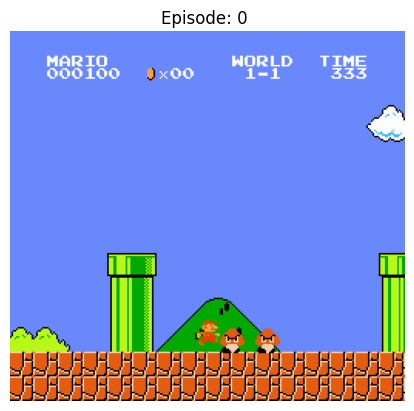

100%|██████████| 1/1 [00:25<00:00, 25.61s/it]


Episode 1 score = 676.0, average score = 676.0


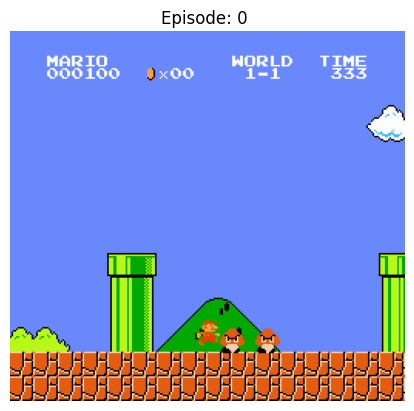

In [7]:
# For Testing
run(training_mode=False, pretrained=True, double_dqn=False, num_episodes=1, exploration_max = 0.05)

----------------------------------------------------------------